In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


from IPython.display import Image

In [2]:
df_merged = pd.read_csv('merged_hydro_climate.csv')

In [3]:
df_merged.head(5)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
0,2023-06-03 13:00:00,consumer_device_3_data_user_11,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,11,0.0,0,0,1
1,2023-06-03 13:00:00,consumer_device_3_data_user_3,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,3,0.0,1,0,0
2,2023-06-03 13:00:00,consumer_device_3_data_user_6,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,6,0.0,0,1,0
3,2023-06-03 13:00:00,consumer_device_3_data_user_10,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,10,0.0,1,0,0
4,2023-06-03 13:00:00,consumer_device_3_data_user_5,0.0,0.0,0.0,0.0,0.0,7.199731,-2.448126,-0.034195,...,0.0,99.972656,2023-06-03,13:00:00,consumer_device_3,5,0.0,0,0,1


In [4]:
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

In [5]:
df_merged.tail(5)

,date_time,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),...,Snowfall (mm),Snow Cover (%),date,time,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
3262636,2024-09-23 23:00:00,consumer_device_6_data_user_7,0.000000,0.00,0.000000,0.000000,0.000000,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_6,7,0.0000,0,1,0
3262637,2024-09-23 23:00:00,consumer_device_10_data_user_3,0.107500,0.11,0.004523,0.385000,0.008021,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_10,3,197.6050,0,0,1
3262638,2024-09-23 23:00:00,consumer_device_35_data_user_6,1.715000,1.94,0.169196,0.833333,0.286159,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_35,6,199.5425,1,0,0
3262639,2024-09-23 23:00:00,consumer_device_31_data_user_6,0.000000,0.00,0.000000,0.000000,0.000000,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_31,6,0.0000,0,1,0
3262640,2024-09-23 23:00:00,consumer_device_12_data_user_3,0.943333,1.01,0.055814,0.367500,0.065902,4.977533,0.843713,0.055191,...,0.0,0.0,2024-09-23,23:00:00,consumer_device_12,3,185.9750,0,0,1


In [6]:
df_merged.columns

Index(['date_time', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)',
       'Dewpoint Temperature (°C)', 'U Wind Component (m/s)',
       'V Wind Component (m/s)', 'Total Precipitation (mm)', 'Snowfall (mm)',
       'Snow Cover (%)', 'date', 'time', 'consumer_device', 'data_user',
       'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

## Linear Regression Performance on Test data and calculated across all users together based on hourly energy consumption. Fast Baseline model ignoring past consumption, only using current electrical, climate, time and source features.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Train-test split by time (last month as test set)
df_train = df_merged.loc[df_merged.date_time <= pd.to_datetime('2024-08-23 23:00:00'), :]
df_test  = df_merged.loc[df_merged.date_time >  pd.to_datetime('2024-08-23 23:00:00'), :]

# Create time features
for d in [df_train, df_test]:
    d['hour'] = d['date_time'].dt.hour
    d['dayofweek'] = d['date_time'].dt.dayofweek
    d['month'] = d['date_time'].dt.month

# Encode categorical features with LabelEncoder (fast)
categorical_cols = ['Source', 'consumer_device', 'data_user']
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

# Features used for baseline
features = [
    # Electrical/consumption
    'current_mean', 'current_max', 'current_std',
    'power_factor_mean', 'voltage_value',
    'is_red', 'is_blue', 'is_yellow',

    # Climate
    'Temperature (°C)', 'Dewpoint Temperature (°C)',
    'U Wind Component (m/s)', 'V Wind Component (m/s)',
    'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)',

    # Device / Source
    'Source', 'consumer_device', 'data_user',

    # Time features
    'hour', 'dayofweek', 'month'
]

# Define X, y
target = 'kwh_sum'
X_train = df_train[features]
y_train = df_train[target]
X_test  = df_test[features]
y_test  = df_test[target]

# Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Metrics
print("Linear Regression Performance (Fast Version):")
print(f"RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.4f}")


/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/2850168506.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['hour'] = d['date_time'].dt.hour
/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/2850168506.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['dayofweek'] = d['date_time'].dt.dayofweek
/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/2850168506.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Linear Regression Performance (Fast Version):
RMSE: 0.1566
MAE: 0.0441
R²: 0.8986


In [8]:
# Check valid consumption for training set
df_train['valid_consumption'] = df_train['kwh_sum'].between(0, 7)
misleading_train = df_train[~df_train['valid_consumption']]

print(f"Training set: {len(df_train)} records")
print(f"Potentially misleading in training set: {len(misleading_train)}")
print(misleading_train.head())

# Check valid consumption for test set
df_test['valid_consumption'] = df_test['kwh_sum'].between(0, 7)
misleading_test = df_test[~df_test['valid_consumption']]

print(f"Test set: {len(df_test)} records")
print(f"Potentially misleading in test set: {len(misleading_test)}")
print(misleading_test.head())


Training set: 2983909 records
Potentially misleading in training set: 19
                 date_time  Source  current_mean  current_max  current_std   
479839 2023-11-26 03:00:00     552     38.190833        38.67     0.265106  \
480246 2023-11-26 04:00:00     552     38.135833        38.64     0.263868   
622686 2023-12-09 06:00:00     552     38.040833        38.38     0.134263   
623483 2023-12-09 08:00:00     552     37.997500        38.60     0.332350   
630743 2023-12-10 00:00:00     552     37.178333        39.14     2.235677   

        power_factor_mean   kwh_sum  Temperature (°C)   
479839           0.970000  7.040619         -7.650595  \
480246           0.965833  7.000227         -6.713309   
622686           0.968333  7.552887        -11.738455   
623483           0.967500  7.393296         -7.479147   
630743           0.922500  7.322296        -16.229559   

        Dewpoint Temperature (°C)  U Wind Component (m/s)  ...   
479839                 -15.737463               -

/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/816335339.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['valid_consumption'] = df_train['kwh_sum'].between(0, 7)
/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/816335339.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['valid_consumption'] = df_test['kwh_sum'].between(0, 7)


In [9]:
# Summary of kwh_sum in the test set
print("Test set kwh_sum range:")
print("Min:", df_test['kwh_sum'].min())
print("Max:", df_test['kwh_sum'].max())

# Flag any values outside 0–7 kWh
misleading_test = df_test[~df_test['kwh_sum'].between(0, 7)]

print(f"Number of records in test set: {len(df_test)}")
print(f"Number of potentially misleading records: {len(misleading_test)}")
print(misleading_test.head())

Test set kwh_sum range:
Min: 0.0
Max: 6.932782349
Number of records in test set: 278732
Number of potentially misleading records: 0
Empty DataFrame
Columns: [date_time, Source, current_mean, current_max, current_std, power_factor_mean, kwh_sum, Temperature (°C), Dewpoint Temperature (°C), U Wind Component (m/s), V Wind Component (m/s), Total Precipitation (mm), Snowfall (mm), Snow Cover (%), date, time, consumer_device, data_user, voltage_value, is_red, is_blue, is_yellow, hour, dayofweek, month, valid_consumption]
Index: []

[0 rows x 26 columns]


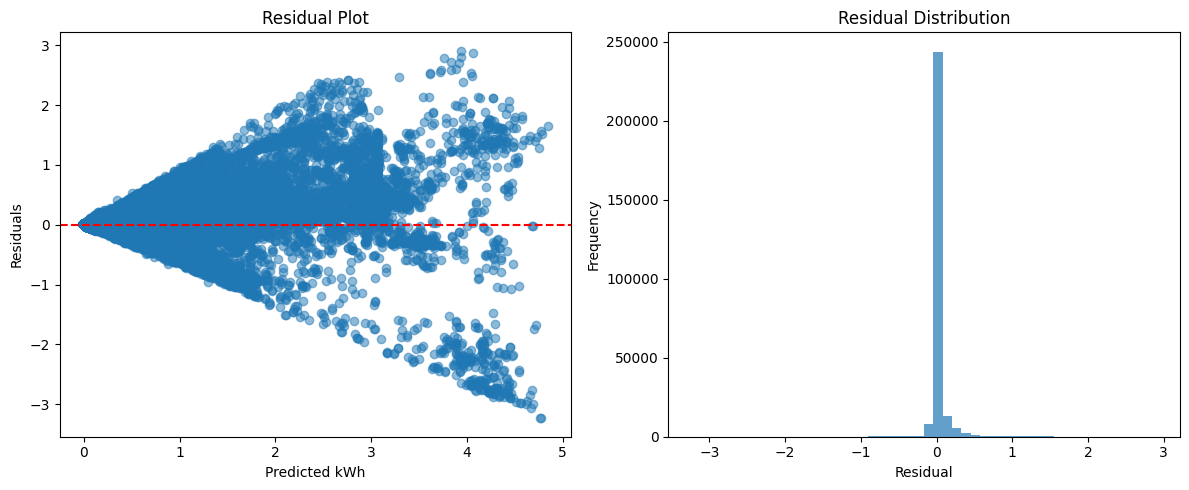

In [10]:
import matplotlib.pyplot as plt

# Residuals
residuals = y_test - y_pred_lr

plt.figure(figsize=(12,5))

# 1. Residual plot
plt.subplot(1,2,1)
plt.scatter(y_pred_lr, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted kWh")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# 2. Histogram of residuals
plt.subplot(1,2,2)
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution")

plt.tight_layout()
plt.show()


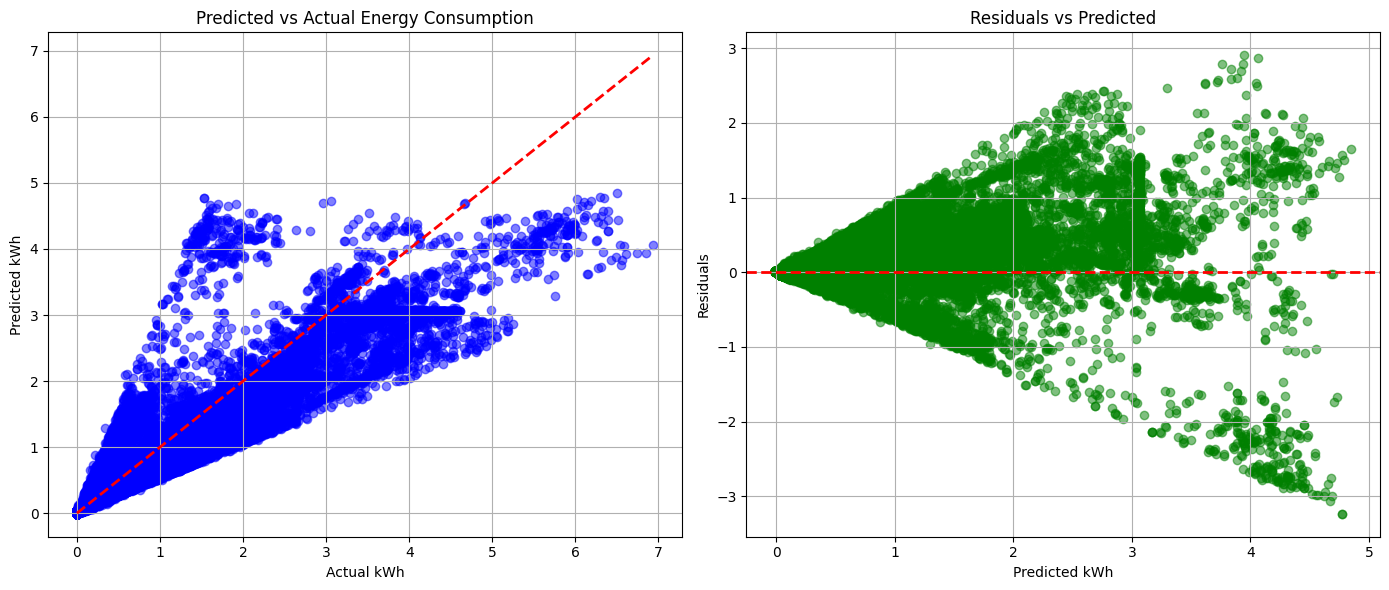

In [11]:
# Predicted values and residuals
y_pred = y_pred_lr  # from Linear Regression
residuals = y_test - y_pred

plt.figure(figsize=(14,6))

# Predicted vs Actual
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual kWh")
plt.ylabel("Predicted kWh")
plt.title("Predicted vs Actual Energy Consumption")
plt.grid(True)

# Residual Plot
plt.subplot(1,2,2)
plt.scatter(y_pred, residuals, alpha=0.5, color='green')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.xlabel("Predicted kWh")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

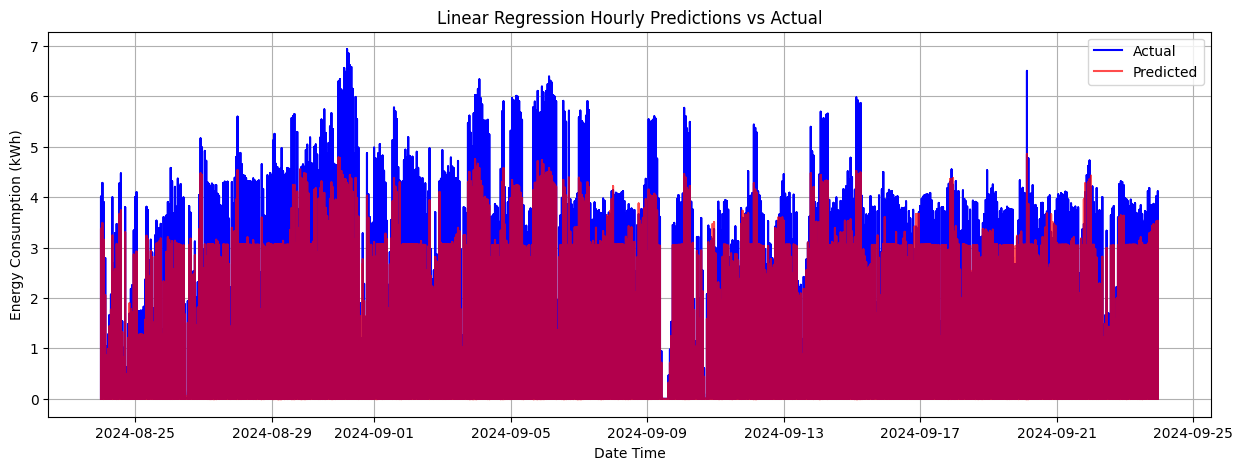

In [12]:
import matplotlib.pyplot as plt

# Sort test set by datetime
df_test_sorted = df_test.sort_values('date_time').reset_index(drop=True)

# Align predictions with sorted test set
y_pred_sorted = y_pred_lr  # already in same order as X_test after reset_index

plt.figure(figsize=(15,5))
plt.plot(df_test_sorted['date_time'], df_test_sorted['kwh_sum'], label='Actual', color='blue')
plt.plot(df_test_sorted['date_time'], y_pred_sorted, label='Predicted', color='red', alpha=0.7)
plt.xlabel("Date Time")
plt.ylabel("Energy Consumption (kWh)")
plt.title("Linear Regression Hourly Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()


## Baseline time-series regression model with lag features for all sources and on hourly energy consumption with LabelEncoder. Time-series dependency captures past consumtion. Source included as feature and lag helps differentiate patterns.

In [13]:
# 1. Create lag features
lags = [1, 24]  # 1 hour ago, 24 hours ago
for lag in lags:
    df_merged[f'kwh_lag_{lag}'] = df_merged['kwh_sum'].shift(lag)

# Drop rows with NaN due to lag features
df_merged = df_merged.dropna(subset=[f'kwh_lag_{lag}' for lag in lags])

# 2. Train-test split by time
split_date = pd.to_datetime('2024-08-23 23:00:00')
df_train = df_merged.loc[df_merged.date_time <= split_date, :]
df_test  = df_merged.loc[df_merged.date_time >  split_date, :]


# 3. Create time features
for d in [df_train, df_test]:
    d['hour'] = d['date_time'].dt.hour
    d['dayofweek'] = d['date_time'].dt.dayofweek
    d['month'] = d['date_time'].dt.month


# 4. Encode categorical features
categorical_cols = ['Source', 'consumer_device', 'data_user']
for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))


# 5. Define features and target
features = [
    # Electrical/consumption
    'current_mean', 'current_max', 'current_std',
    'power_factor_mean', 'voltage_value',
    'is_red', 'is_blue', 'is_yellow',

    # Climate
    'Temperature (°C)', 'Dewpoint Temperature (°C)',
    'U Wind Component (m/s)', 'V Wind Component (m/s)',
    'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)',

    # Device / Source
    'Source', 'consumer_device', 'data_user',

    # Time features
    'hour', 'dayofweek', 'month'
]

# Add lag features
features += [f'kwh_lag_{lag}' for lag in lags]

target = 'kwh_sum'

# 6. Define X, y
X_train = df_train[features]
y_train = df_train[target]
X_test  = df_test[features]
y_test  = df_test[target]

# 7. Train Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)


# 8. Evaluate model
print("Linear Regression with Lag Features Performance:")
print(f"RMSE: {mean_squared_error(y_test, y_pred_lr, squared=False):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lr):.4f}")
print(f"R²: {r2_score(y_test, y_pred_lr):.4f}")


/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/1234269134.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['hour'] = d['date_time'].dt.hour
/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/1234269134.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['dayofweek'] = d['date_time'].dt.dayofweek
/var/folders/86/pr4crxy17sb_6r9w9xx0v3rw0000gn/T/ipykernel_46924/1234269134.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Linear Regression with Lag Features Performance:
RMSE: 0.1566
MAE: 0.0441
R²: 0.8986


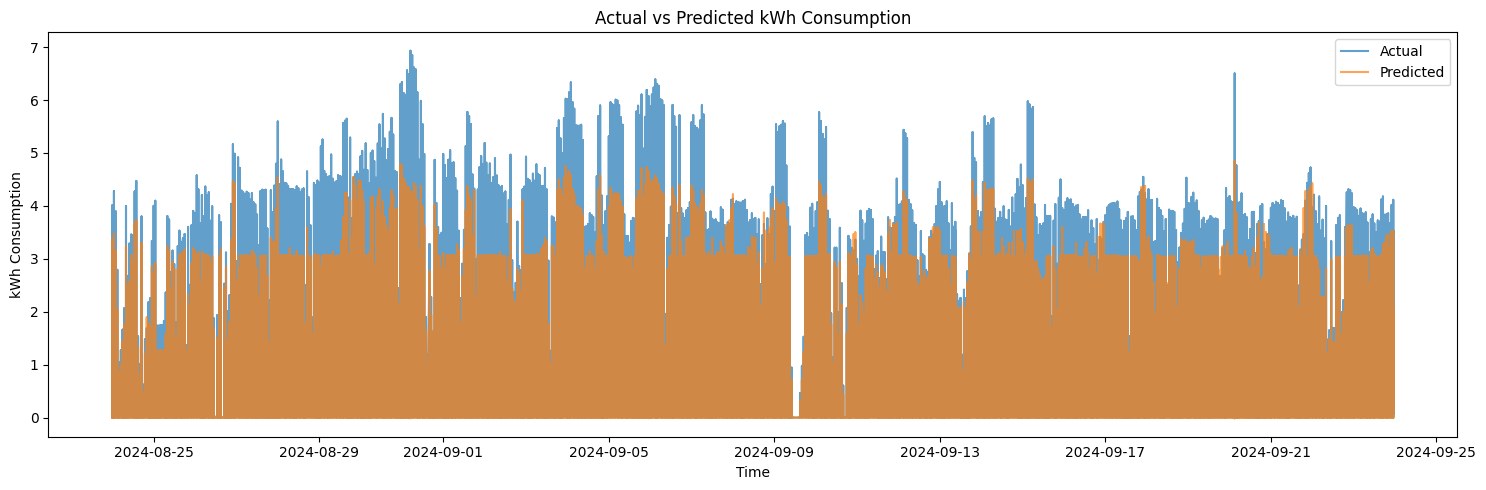

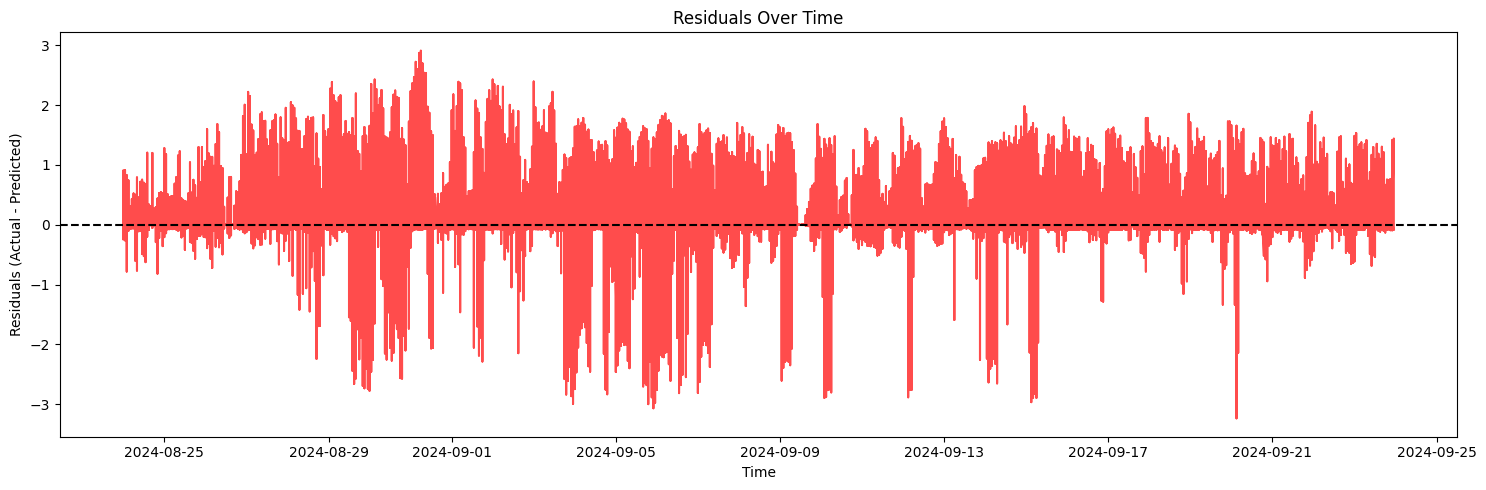

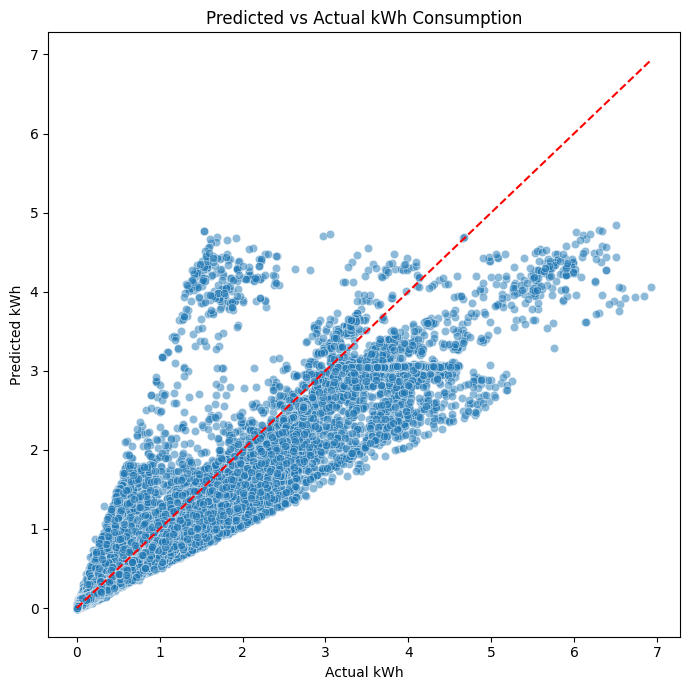

In [14]:
# Combine test results for plotting
df_plot = df_test.copy()
df_plot['y_pred'] = y_pred_lr
df_plot['residuals'] = df_plot[target] - df_plot['y_pred']

# Actual vs Predicted over time
plt.figure(figsize=(15,5))
plt.plot(df_plot['date_time'], df_plot[target], label='Actual', alpha=0.7)
plt.plot(df_plot['date_time'], df_plot['y_pred'], label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('kWh Consumption')
plt.title('Actual vs Predicted kWh Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Residuals over time
plt.figure(figsize=(15,5))
plt.plot(df_plot['date_time'], df_plot['residuals'], color='red', alpha=0.7)
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Time')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals Over Time')
plt.tight_layout()
plt.show()


# Predicted vs Actual scatter plot
plt.figure(figsize=(7,7))
sns.scatterplot(x=df_plot[target], y=df_plot['y_pred'], alpha=0.5)
plt.plot([df_plot[target].min(), df_plot[target].max()],
         [df_plot[target].min(), df_plot[target].max()],
         color='red', linestyle='--')
plt.xlabel('Actual kWh')
plt.ylabel('Predicted kWh')
plt.title('Predicted vs Actual kWh Consumption')
plt.tight_layout()
plt.show()


In [15]:
df_daily_merged = pd.read_csv('daily_merged_hydro_climate.csv')

In [16]:
df_daily_merged.tail(5)

,date,Source,current_mean,current_max,current_std,power_factor_mean,kwh_sum,Temperature (°C)_mean,Temperature (°C)_min,Temperature (°C)_max,...,V Wind Component (m/s)_mean,Total Precipitation (mm)_sum,Snowfall (mm)_sum,Snow Cover (%)_mean,consumer_device,data_user,voltage_value,is_red,is_blue,is_yellow
136404,2024-09-23,consumer_device_8_data_user_10,0.086007,0.10,0.010036,0.744965,0.316940,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_8,10,203.113368,1,0,0
136405,2024-09-23,consumer_device_28_data_user_10,8.006736,23.97,4.669972,0.728542,26.101382,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_28,10,181.688160,1,0,0
136406,2024-09-23,consumer_device_10_data_user_13,0.015000,0.07,0.022770,0.220486,0.048129,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_10,13,190.297118,1,0,0
136407,2024-09-23,consumer_device_36_data_user_16,0.070069,0.08,0.004495,0.747569,0.261421,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_36,16,206.630625,0,0,1
136408,2024-09-23,consumer_device_22_data_user_12,0.023611,0.05,0.024526,0.354340,0.062540,13.384137,4.670419,21.034174,...,-0.223926,0.000249,0.0,0.0,consumer_device_22,12,104.095278,1,0,0


In [17]:
df_daily_merged.columns

Index(['date', 'Source', 'current_mean', 'current_max', 'current_std',
       'power_factor_mean', 'kwh_sum', 'Temperature (°C)_mean',
       'Temperature (°C)_min', 'Temperature (°C)_max',
       'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min',
       'Dewpoint Temperature (°C)_max', 'U Wind Component (m/s)_mean',
       'V Wind Component (m/s)_mean', 'Total Precipitation (mm)_sum',
       'Snowfall (mm)_sum', 'Snow Cover (%)_mean', 'consumer_device',
       'data_user', 'voltage_value', 'is_red', 'is_blue', 'is_yellow'],
      dtype='object')

Devices data range: 2023-06-03 12:25:00 to 2024-09-23 23:55:00. 
Climate data range: 2023-06-03 13:00:00 to 2024-10-25 00:00:00. 
Overlap range: 2023-06-03 13:00:00 to 2024-09-23 23:55:00.

** Baseline model with Sarimax and Prophet

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from math import sqrt
from prophet import Prophet

In [19]:
# Load & Prepare Data
df = df_daily_merged.copy()

# Ensure datetime and sort
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df = df.set_index('date')

# Aggregate Duplicates
df = df.groupby(df.index).agg({
    'kwh_sum': 'sum',
    'Temperature (°C)_mean': 'mean',
    'Temperature (°C)_min': 'min',
    'Temperature (°C)_max': 'max',
    'Dewpoint Temperature (°C)_mean': 'mean',
    'Dewpoint Temperature (°C)_min': 'min',
    'Dewpoint Temperature (°C)_max': 'mean',
    'U Wind Component (m/s)_mean': 'mean',
    'V Wind Component (m/s)_mean': 'mean',
    'Total Precipitation (mm)_sum': 'sum',
    'Snowfall (mm)_sum': 'sum',
    'Snow Cover (%)_mean': 'mean',
    'current_mean': 'mean',
    'current_max': 'max',
    'current_std': 'mean',
    'power_factor_mean': 'mean',
    'voltage_value': 'mean'
})

# Set daily frequency and interpolate missing days
df = df.asfreq('D').interpolate()


# Feature Engineering
df['kwh_sum_lag1'] = df['kwh_sum'].shift(1)
df['kwh_sum_lag7'] = df['kwh_sum'].shift(7)
df['kwh_sum_roll7'] = df['kwh_sum'].rolling(7).mean()
df['kwh_sum_roll30'] = df['kwh_sum'].rolling(30).mean()
df['HDD'] = np.maximum(0, 18 - df['Temperature (°C)_mean'])
df['CDD'] = np.maximum(0, df['Temperature (°C)_mean'] - 22)

df = df.dropna()


# Define Target & Features
target = 'kwh_sum'

climate_features = [
    'Temperature (°C)_mean', 'Total Precipitation (mm)_sum'
]
device_features = ['current_mean']
engineered_features = ['kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7','kwh_sum_roll30','HDD','CDD']

exog_features = climate_features + device_features + engineered_features


In [20]:
# Train-Test Split
train = df.loc[:'2024-08-23']
test = df.loc['2024-08-24':'2024-09-23']

X_train = train[exog_features]
y_train = train[target]
X_test = test[exog_features]
y_test = test[target]


In [21]:
# Scale Exogenous Variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [22]:
# SARIMAX Model (log-transform)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

sarimax_model = SARIMAX(
    y_train_log,
    exog=X_train_scaled,
    order=(1,1,0),
    seasonal_order=(0,1,1,7)
)

sarimax_fit = sarimax_model.fit(disp=False, method='powell', maxiter=500)

# Forecast
sarimax_pred_log = sarimax_fit.predict(start=y_test_log.index[0], end=y_test_log.index[-1], exog=X_test_scaled)
sarimax_pred = np.expm1(sarimax_pred_log)

# Evaluate SARIMAX
rmse_sarimax = sqrt(mean_squared_error(y_test, sarimax_pred))
mae_sarimax = mean_absolute_error(y_test, sarimax_pred)
print("SARIMAX RMSE:", rmse_sarimax)
print("SARIMAX MAE:", mae_sarimax)


SARIMAX RMSE: 33335.29325775831
SARIMAX MAE: 20126.062347323463


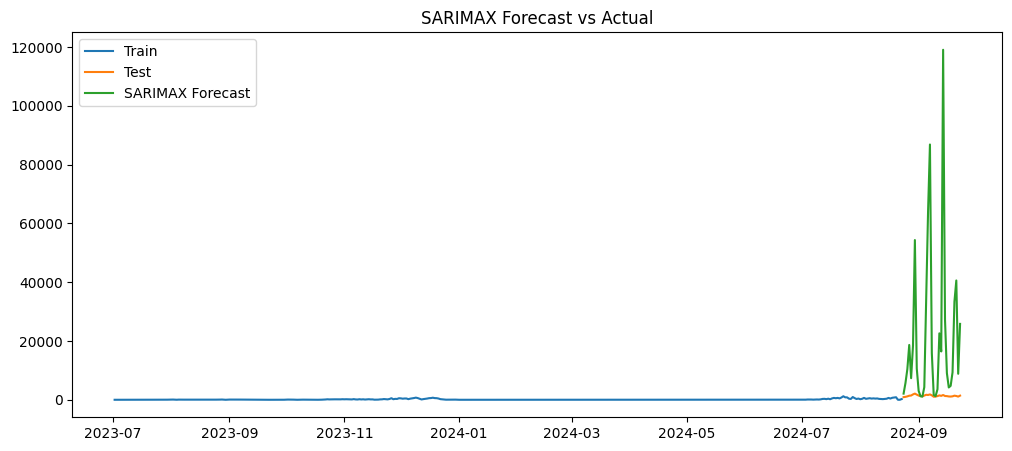

In [23]:
# Plot SARIMAX
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.plot(test.index, sarimax_pred, label='SARIMAX Forecast')
plt.legend()
plt.title("SARIMAX Forecast vs Actual")
plt.show()

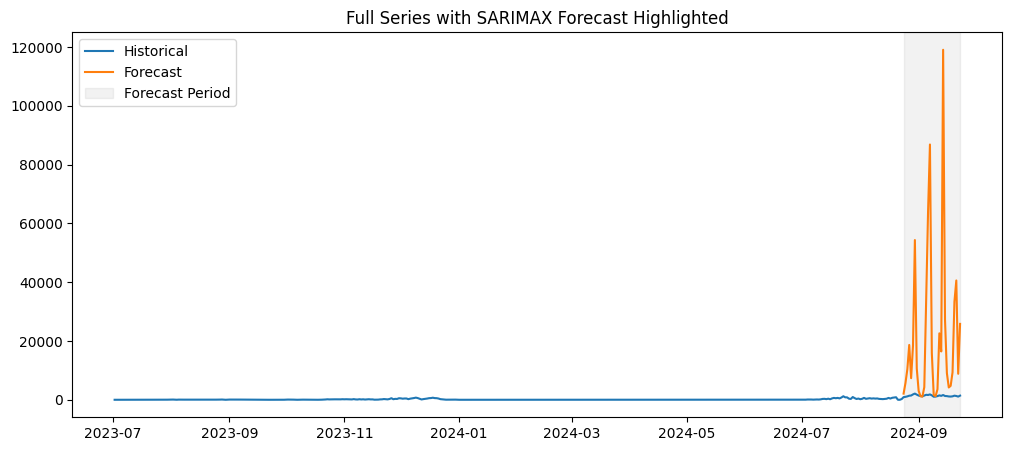

In [24]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df[target], label='Historical')
plt.plot(test.index, sarimax_pred, label='Forecast')
plt.axvspan(test.index[0], test.index[-1], color='grey', alpha=0.1, label='Forecast Period')
plt.legend()
plt.title("Full Series with SARIMAX Forecast Highlighted")
plt.show()

In [25]:
# Prophet Model
prophet_df = df[[target] + climate_features + device_features].reset_index().rename(columns={'date':'ds', target:'y'})

prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]

prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for col in climate_features + device_features:
    prophet_model.add_regressor(col)

prophet_model.fit(prophet_train)

future_test = prophet_test[['ds'] + climate_features + device_features]
prophet_forecast = prophet_model.predict(future_test)

# Evaluate Prophet
rmse_prophet = sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
print("Prophet RMSE:", rmse_prophet)
print("Prophet MAE:", mae_prophet)

13:10:40 - cmdstanpy - INFO - Chain [1] start processing
13:10:40 - cmdstanpy - INFO - Chain [1] done processing
13:10:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:10:40 - cmdstanpy - INFO - Chain [1] start processing
13:10:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 464.05220001830133
Prophet MAE: 428.6513569861451


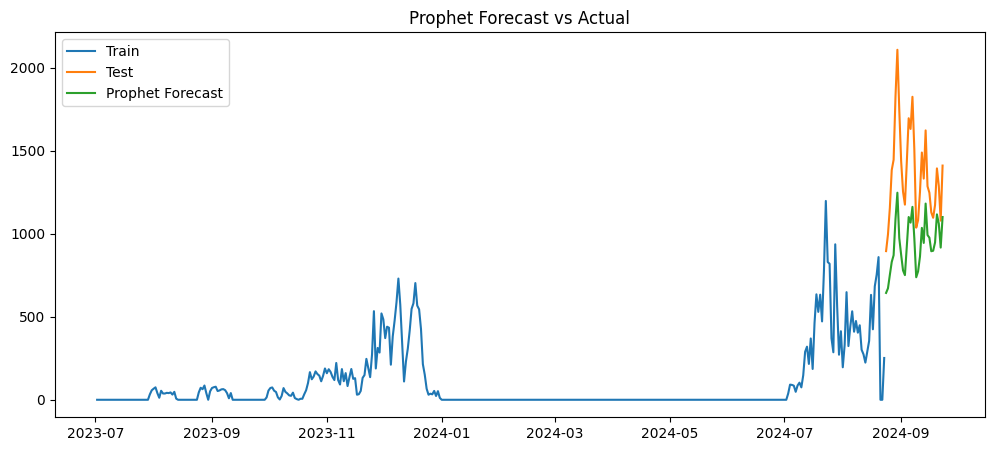

In [26]:
# Plot Prophet
plt.figure(figsize=(12,5))
plt.plot(train.index, y_train, label='Train')
plt.plot(test.index, y_test, label='Test')
plt.plot(test.index, prophet_forecast['yhat'].values, label='Prophet Forecast')
plt.legend()
plt.title("Prophet Forecast vs Actual")
plt.show()

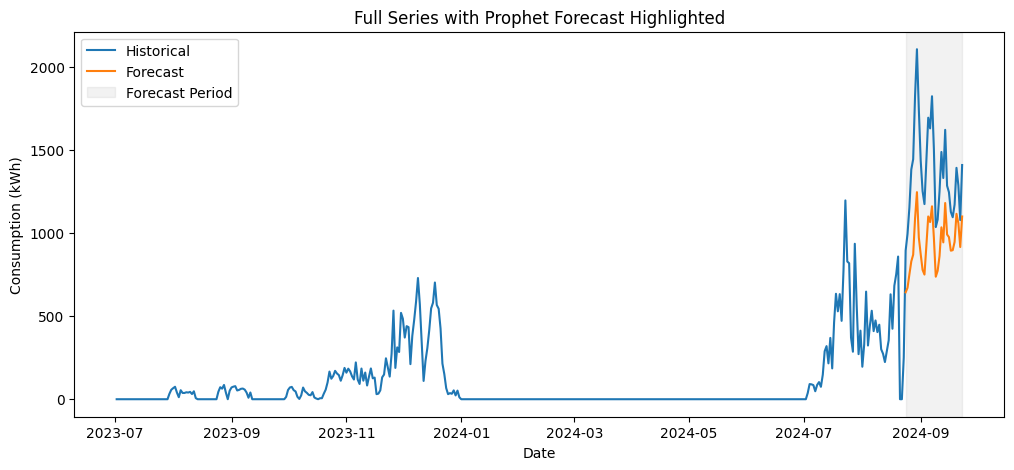

In [27]:
#Full Series Forecast (Historical + Test + Future)
plt.figure(figsize=(12,5))
plt.plot(df.index, df[target], label='Historical')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Forecast')
plt.axvspan(prophet_forecast['ds'].iloc[0], prophet_forecast['ds'].iloc[-1], color='grey', alpha=0.1, label='Forecast Period')
plt.legend()
plt.title("Full Series with Prophet Forecast Highlighted")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.show()

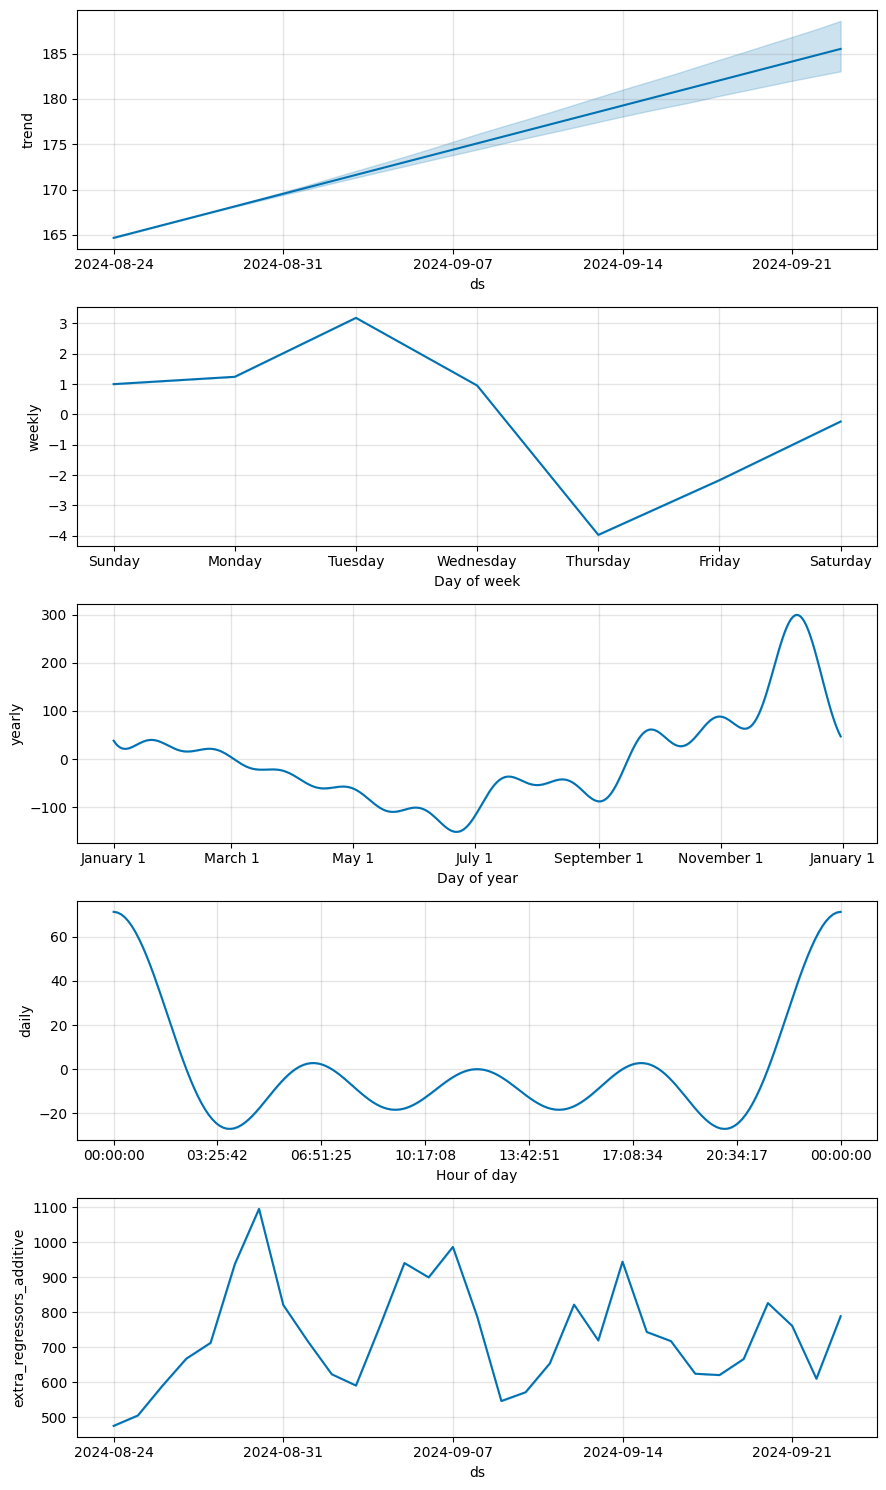

In [28]:
#Components Plot (Trend + Seasonality + Regressors)
prophet_model.plot_components(prophet_forecast)
plt.show()

### Modeling with Prophet using extended list of features.

13:10:48 - cmdstanpy - INFO - Chain [1] start processing
13:10:56 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 2.854028988820277
Prophet MAE: 1.0697960921868366


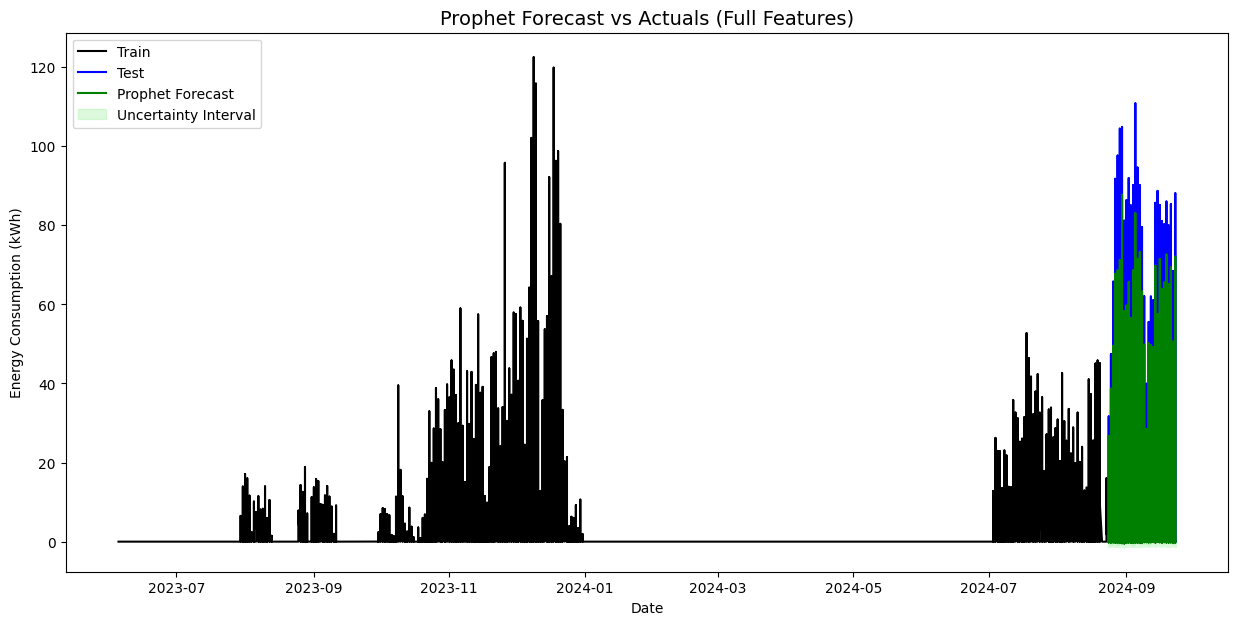

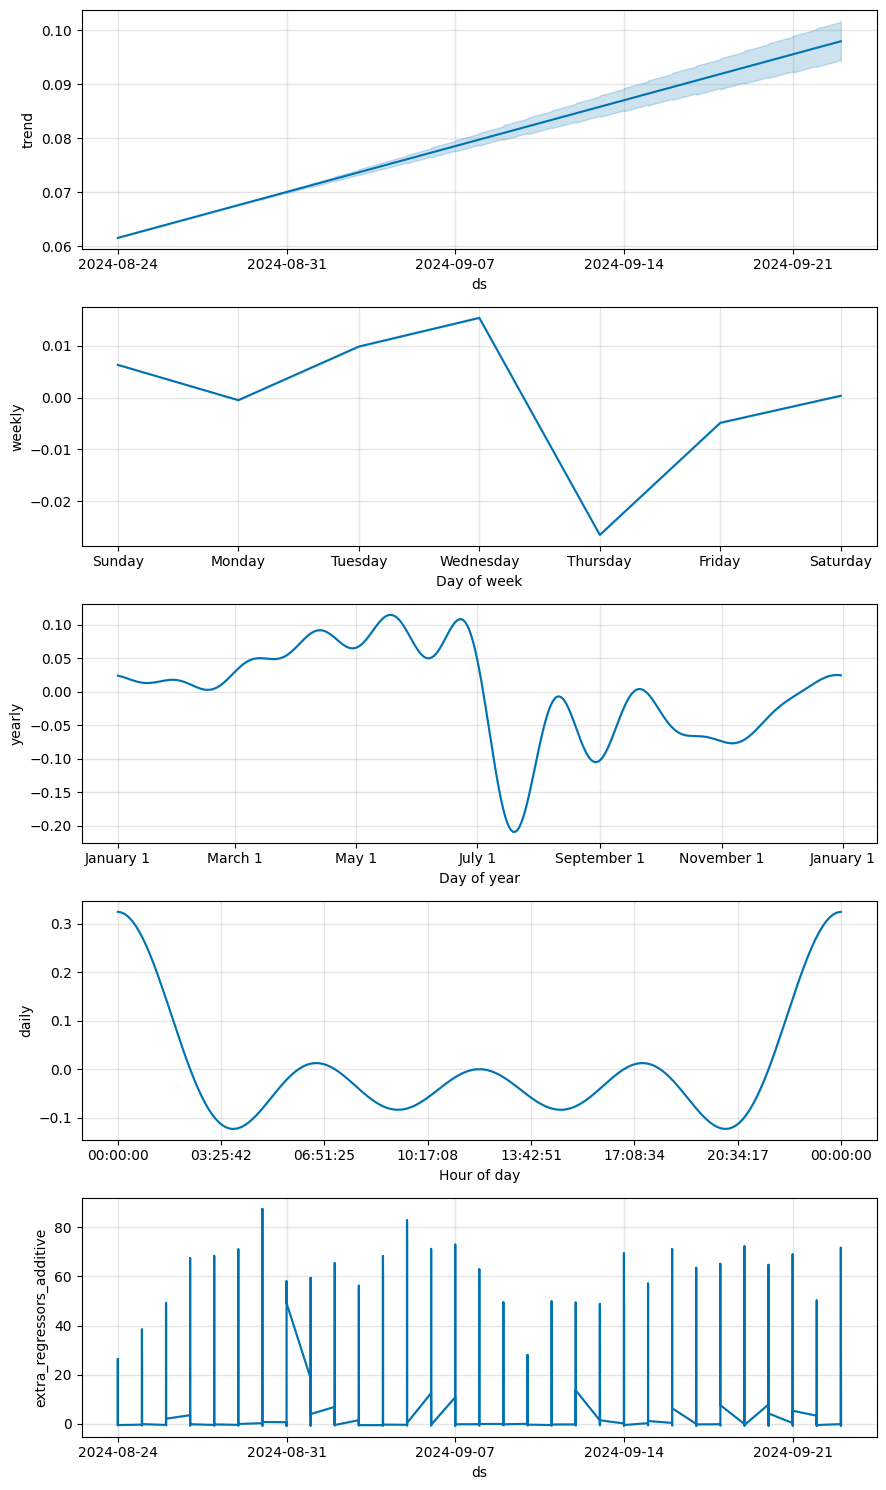

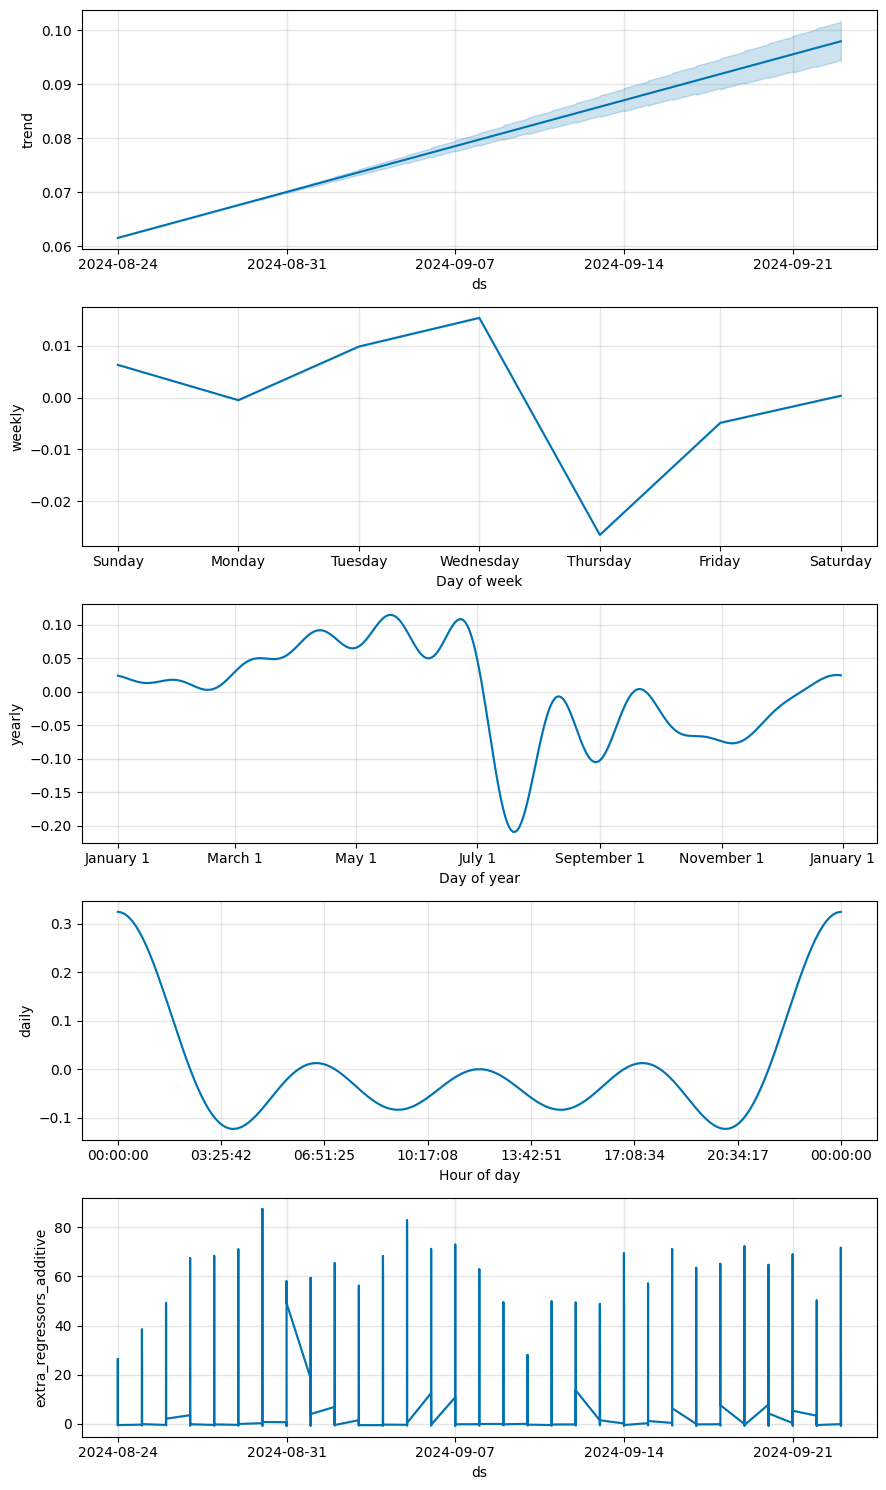

In [29]:
# Feature Engineering

# Snowfall features
df_daily_merged['snowfall_lag7'] = df_daily_merged['Snowfall (mm)_sum'].shift(7)         
df_daily_merged['snowfall_lag30'] = df_daily_merged['Snowfall (mm)_sum'].shift(30)       
df_daily_merged['snowfall_roll30'] = df_daily_merged['Snowfall (mm)_sum'].rolling(30).sum()  

# Snow Cover features
df_daily_merged['snowcover_lag7'] = df_daily_merged['Snow Cover (%)_mean'].shift(7)
df_daily_merged['snowcover_roll30'] = df_daily_merged['Snow Cover (%)_mean'].rolling(30).mean()

# Consumption features
df_daily_merged['kwh_sum_lag1'] = df_daily_merged['kwh_sum'].shift(1)
df_daily_merged['kwh_sum_lag7'] = df_daily_merged['kwh_sum'].shift(7)
df_daily_merged['kwh_sum_roll7'] = df_daily_merged['kwh_sum'].rolling(7).mean()
df_daily_merged['kwh_sum_roll30'] = df_daily_merged['kwh_sum'].rolling(30).mean()
df_daily_merged['HDD'] = np.maximum(0, 18 - df_daily_merged['Temperature (°C)_mean'])
df_daily_merged['CDD'] = np.maximum(0, df_daily_merged['Temperature (°C)_mean'] - 22)

# Drop NaNs caused by lags
df_daily_merged = df_daily_merged.dropna()


# Define Features
target = 'kwh_sum'

climate_features_new = [
    'Temperature (°C)_mean', 'Temperature (°C)_min', 'Temperature (°C)_max',
    'Dewpoint Temperature (°C)_mean', 'Dewpoint Temperature (°C)_min', 'Dewpoint Temperature (°C)_max',
    'U Wind Component (m/s)_mean', 'V Wind Component (m/s)_mean',
    'Total Precipitation (mm)_sum', 
    'Snowfall (mm)_sum', 'Snow Cover (%)_mean',
    'snowfall_lag7', 'snowfall_lag30', 'snowfall_roll30',
    'snowcover_lag7', 'snowcover_roll30'
]

device_features_new = [
    'current_mean', 'current_max', 'current_std',
    'power_factor_mean', 'voltage_value'
]

engineered_features_new = [
    'kwh_sum_lag1','kwh_sum_lag7','kwh_sum_roll7','kwh_sum_roll30','HDD','CDD'
]

exog_features_new = climate_features_new + device_features_new + engineered_features_new


# Prepare Prophet Dataset
prophet_df = df_daily_merged.reset_index().rename(columns={'date':'ds', target:'y'})
prophet_df = prophet_df[['ds', 'y'] + exog_features_new]

# Ensure 'ds' is proper datetime for Prophet (in case if this code runns independently from what I have done before)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Train/Test Split
prophet_train = prophet_df[prophet_df['ds'] <= '2024-08-23']
prophet_test = prophet_df[(prophet_df['ds'] >= '2024-08-24') & (prophet_df['ds'] <= '2024-09-23')]


# Initialize & Fit Prophet
prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)

# Add exogenous regressors
for col in exog_features_new:
    prophet_model.add_regressor(col)

prophet_model.fit(prophet_train)

# Forecast for Test Set
future_test = prophet_test[['ds'] + exog_features_new]
prophet_forecast = prophet_model.predict(future_test)

# Evaluate
rmse_prophet = sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
print("Prophet RMSE:", rmse_prophet)
print("Prophet MAE:", mae_prophet)

# 8. Plot Forecast vs Actuals
plt.figure(figsize=(15,7))
plt.plot(prophet_train['ds'], prophet_train['y'], label="Train", color="black")
plt.plot(prophet_test['ds'], prophet_test['y'], label="Test", color="blue")
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label="Prophet Forecast", color="green")
plt.fill_between(prophet_forecast['ds'],
                 prophet_forecast['yhat_lower'],
                 prophet_forecast['yhat_upper'],
                 color="lightgreen", alpha=0.3, label="Uncertainty Interval")
plt.title("Prophet Forecast vs Actuals (Full Features)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()


# Prophet Components Plot
prophet_model.plot_components(prophet_forecast)

In [31]:
df_climate = pd.read_csv('climate_data.csv')

In [32]:
df_climate.head(5)

,Date Time,Temperature (°C),Dewpoint Temperature (°C),U Wind Component (m/s),V Wind Component (m/s),Total Precipitation (mm),Snowfall (mm),Snow Cover (%),i,j,...,q,r,s,t,u,v,w,x,y,z
0,2023-06-03T13:00:00,7.199731,-2.448126,-0.034195,0.060989,0.000377,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-06-03T14:00:00,6.000620,-2.597540,-0.080688,0.018585,0.000398,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-06-03T15:00:00,4.789972,-2.696951,0.057449,-0.352020,0.000418,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-06-03T16:00:00,3.158746,-2.879324,0.051529,-0.608948,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-06-03T17:00:00,1.671426,-3.255606,0.056137,-0.739838,0.000420,0.0,99.972656,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df_climate = df_climate.drop(columns=['i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

In [34]:
df_climate.columns

Index(['Date Time', 'Temperature (°C)', 'Dewpoint Temperature (°C)',
       'U Wind Component (m/s)', 'V Wind Component (m/s)',
       'Total Precipitation (mm)', 'Snowfall (mm)', 'Snow Cover (%)'],
      dtype='object')

### Climate only forecast.

In [35]:
# Prepare Climate Dataset
df_climate['Date Time'] = pd.to_datetime(df_climate['Date Time'])
df_climate.set_index('Date Time', inplace=True)